# Managing flows with signals

This is an example, when process could be controlled with signals and when messages are required instead.

In [1]:
from IPython.display import display, JSON
from requests import get, post

## Example process

At first, we need to design a process with a such event sub-process:

In [2]:
bpmn = open("example-signals.bpmn").read()

Then we define some helpers to render the state of the process:

In [3]:
from IPython.display import display
from pandas import DataFrame as df
import json

config = {
    "style": {
        "height": "400px"
    },
    "zoom": 1.1
}
render = lambda update={}: display({
    "application/bpmn+xml": bpmn,
    "application/bpmn+json": json.dumps(config | update)
}, raw=True)
variables = lambda d={}: [{
    "name": k,
    "type": v["type"],
    "value": v["value"],
} for k,v in d.items()]

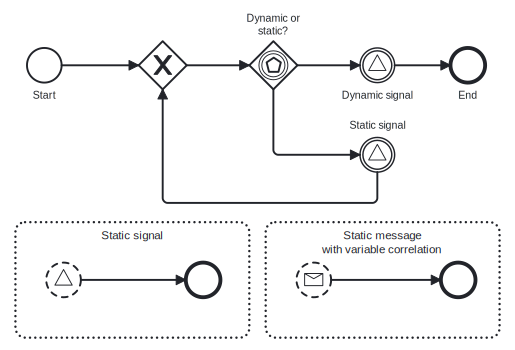

In [4]:
render()

## Deploying a process

Next, we need to deploy it:

In [5]:
base_url = "http://localhost:8080/engine-rest"
definition_key = "example-signals"

In [6]:
definition_id = list(post(f"{base_url}/deployment/create", files={
    "deployment-name": "Example",
    "deploy-changed-only": False,
    "deployment-source": "notebook",
    "bpmn": bpmn
}).json()["deployedProcessDefinitions"].values())[0]["id"]

## Starting new instances

Once it's deployed, we are able to start instance for it:

In [7]:
for i in range(10):
    payload = dict(variables=dict(index=dict(type="Long", value=i)))
    instance_id = post(f"{base_url}/process-definition/{definition_id}/start", data=json.dumps(payload), headers={"content-type": "application/json"}).json()["id"]

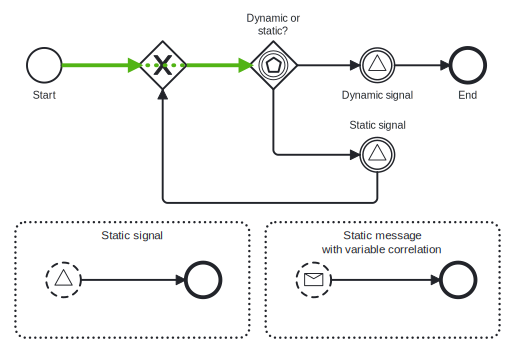

In [8]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processDefinitionId": definition_id}).json()))

In [9]:
df(variables(get(f"{base_url}/process-instance/{instance_id}/variables").json()))

,name,type,value
0,index,Long,9


## Signal broadcast

Signal is the recommended way to broadcast event to multiple processes.

In [10]:
signal = {
    "name": "Static signal",
    "variables": {
        "motd": {
            "type": "String",
            "value": "Hello World!",
        },
    },
}

In [11]:
_ = post(f"{base_url}/signal", json=signal)

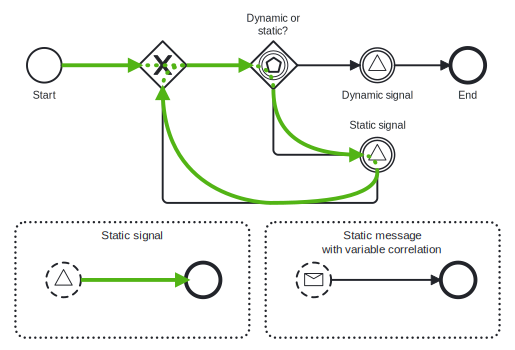

In [12]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processDefinitionId": definition_id}).json()))

In [13]:
df(variables(get(f"{base_url}/process-instance/{instance_id}/variables").json()))

,name,type,value
0,motd,String,Hello World!
1,index,Long,9


## Targeted message and signal

Event sub-process of a particular process cannot be targeted with dynamic signal, because the names of those signals must be resolvable right when the process is deployed.

That said, those could be targeted with message.

In [14]:
message = {
    "messageName": "Static message",
    "correlationKeys": {
        "index": {
            "type": "Long",
            "value": 9,
        },
    },
    "variables": {
        "motd": {
            "type": "String",
            "value": "Here be dragons!",
        },
    },
    "all": True,
    "resultEnabled": True,
    "variablesInResultEnabled": True
}

In [15]:
df(variables(post(f"{base_url}/message", json=message).json()[0]["variables"]))

,name,type,value
0,motd,String,Hello World!
1,index,Long,9


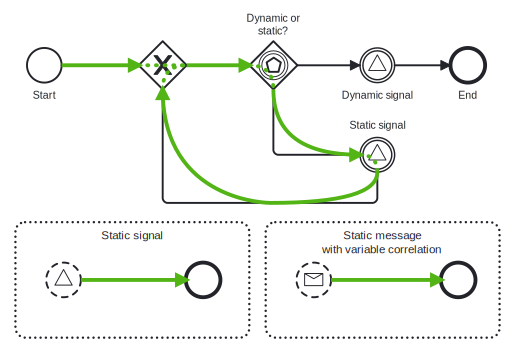

In [16]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processDefinitionId": definition_id}).json()))

But if sinal catch event is created within the process flow, the signal name could be an expression with variable substitution. This makes it possible to target exact processes also with signals.

In [17]:
signal = {
    "name": "Dynamic 9",
}

In [18]:
_ = post(f"{base_url}/signal", json=signal)

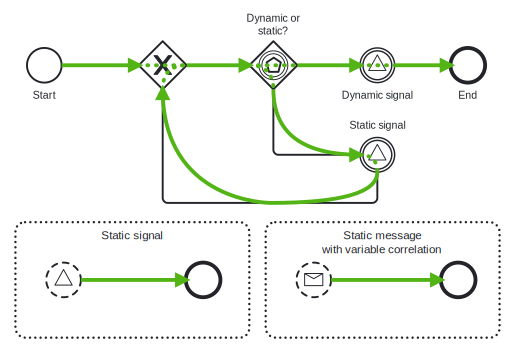

In [19]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processDefinitionId": definition_id}).json()))

In [20]:
for i in range(10):
    signal = dict(name=f"Dynamic {i}")
    post(f"{base_url}/signal", json=signal)

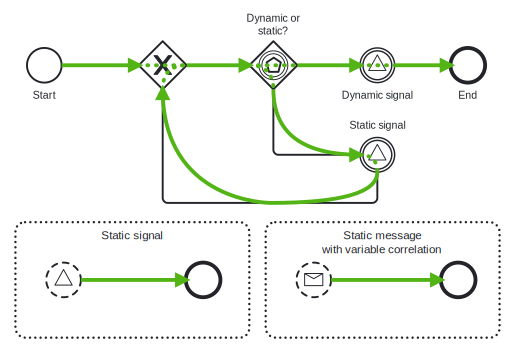

In [21]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processDefinitionId": definition_id}).json()))